In [1]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import cv2
from tqdm.notebook import tqdm

from model import MySeNet
from dataset import FaceDataset
from train import train, validate




In [2]:
data_dir = '../appa-real-release'
img_size = 224
age_stddev = 1.0
batch_size = 40

train_dataset = FaceDataset(data_dir, "train", img_size=img_size, augment=False, age_stddev=age_stddev)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

valid_dataset = FaceDataset(data_dir, "valid", img_size=img_size, augment=False, age_stddev=age_stddev)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

test_dataset = FaceDataset(data_dir, "test", img_size=img_size, augment=False, age_stddev=age_stddev)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

dftrain = pd.read_csv(data_dir + '/gt_avg_train.csv')
dfvalid = pd.read_csv(data_dir + '/gt_avg_valid.csv')
dftest = pd.read_csv(data_dir + '/gt_avg_test.csv')

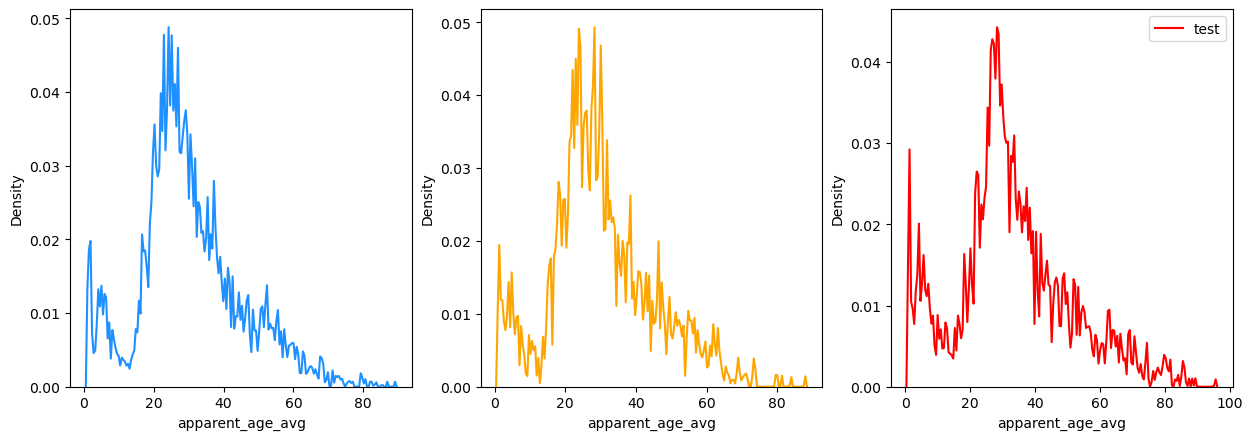

In [3]:
ages_train = dftrain['apparent_age_avg']
ages_valid = dfvalid['apparent_age_avg']
ages_test = dftest['apparent_age_avg']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
sns.kdeplot(ages_train, ax = axes[0], color="dodgerblue", label='train', bw_adjust=0.05)
sns.kdeplot(ages_valid, ax = axes[1], color="orange", label="validation", bw_adjust=0.05)
sns.kdeplot(ages_test, ax = axes[2], color="red", label="test", bw_adjust=0.05)
plt.legend()
plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MySeNet().to(device)
resume_path = 'with_gender_biggerbatches_trick_smalllr/checkpoint/epoch024_0.76385_4.2838.pth'

In [5]:
checkpoint = torch.load(resume_path, map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])

gt, preds,_, _, test_mae = validate(test_loader, model, None, 0, device)
print (str(checkpoint['epoch']) + '=> test mae: ', test_mae)

  0%|          | 0/50 [00:00<?, ?it/s]

25=> test mae:  5.124487551326578


Text(0, 0.5, 'residual (predicted - ground truth)')

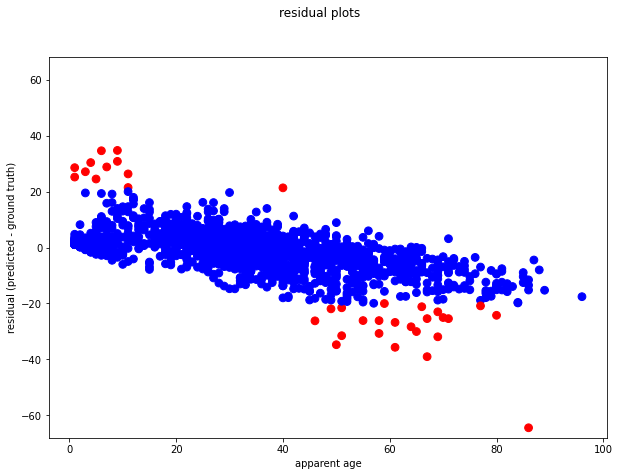

In [6]:
diffs = preds - gt
c = np.where(np.abs(diffs)>20, 1, 0)
colors = ['blue', 'red']
cmap = matplotlib.colors.ListedColormap(colors) 
fig = plt.figure(figsize=(10,7))
plt.scatter(gt,diffs, s=60, c=c, cmap=cmap)
plt.ylim([-68,68])

fig.suptitle('residual plots')
plt.xlabel('apparent age')
plt.ylabel('residual (predicted - ground truth)')
#fig.savefig('residuals.jpg')

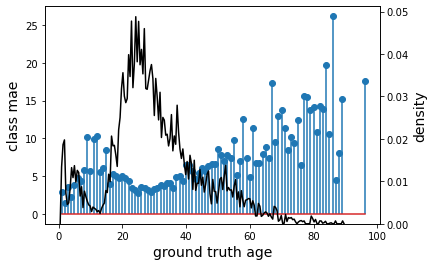

In [7]:
sets, counts = np.unique(gt, return_counts=True)
idx = np.argsort(gt)
ordered_diffs = np.abs(diffs[idx])
sticks = []
cur=0
for count in counts:
    sticks.append(np.mean(ordered_diffs[cur:cur+count]))
    cur+= count
    
fig,ax = plt.subplots()
ax.stem(sets, sticks)
# set x-axis label
ax.set_xlabel("ground truth age",fontsize=14)
# set y-axis label
ax.set_ylabel("class mae",color="black",fontsize=14)

ax2=ax.twinx()

sns.kdeplot(ages_train, ax = ax2, color="black", label="test", bw_adjust=0.05)
ax2.set_ylabel("density",color="black",fontsize=14)
plt.show()


In [8]:
def rgb(img):
    im = np.empty_like(img)
    im[:,:,0] = img[:,:,2]
    im[:,:,1] = img[:,:,1]
    im[:,:,2] = img[:,:,0]
    return im.astype(np.uint8)

#assemble images with residuals bigger than threshhold
threshhold = 25
idx_big_residuals = np.nonzero( np.where(np.abs(diffs)>threshhold, 1,0) )[0]
l = dftest.iloc[idx_big_residuals].copy()
l['predicted'] = preds[idx_big_residuals]


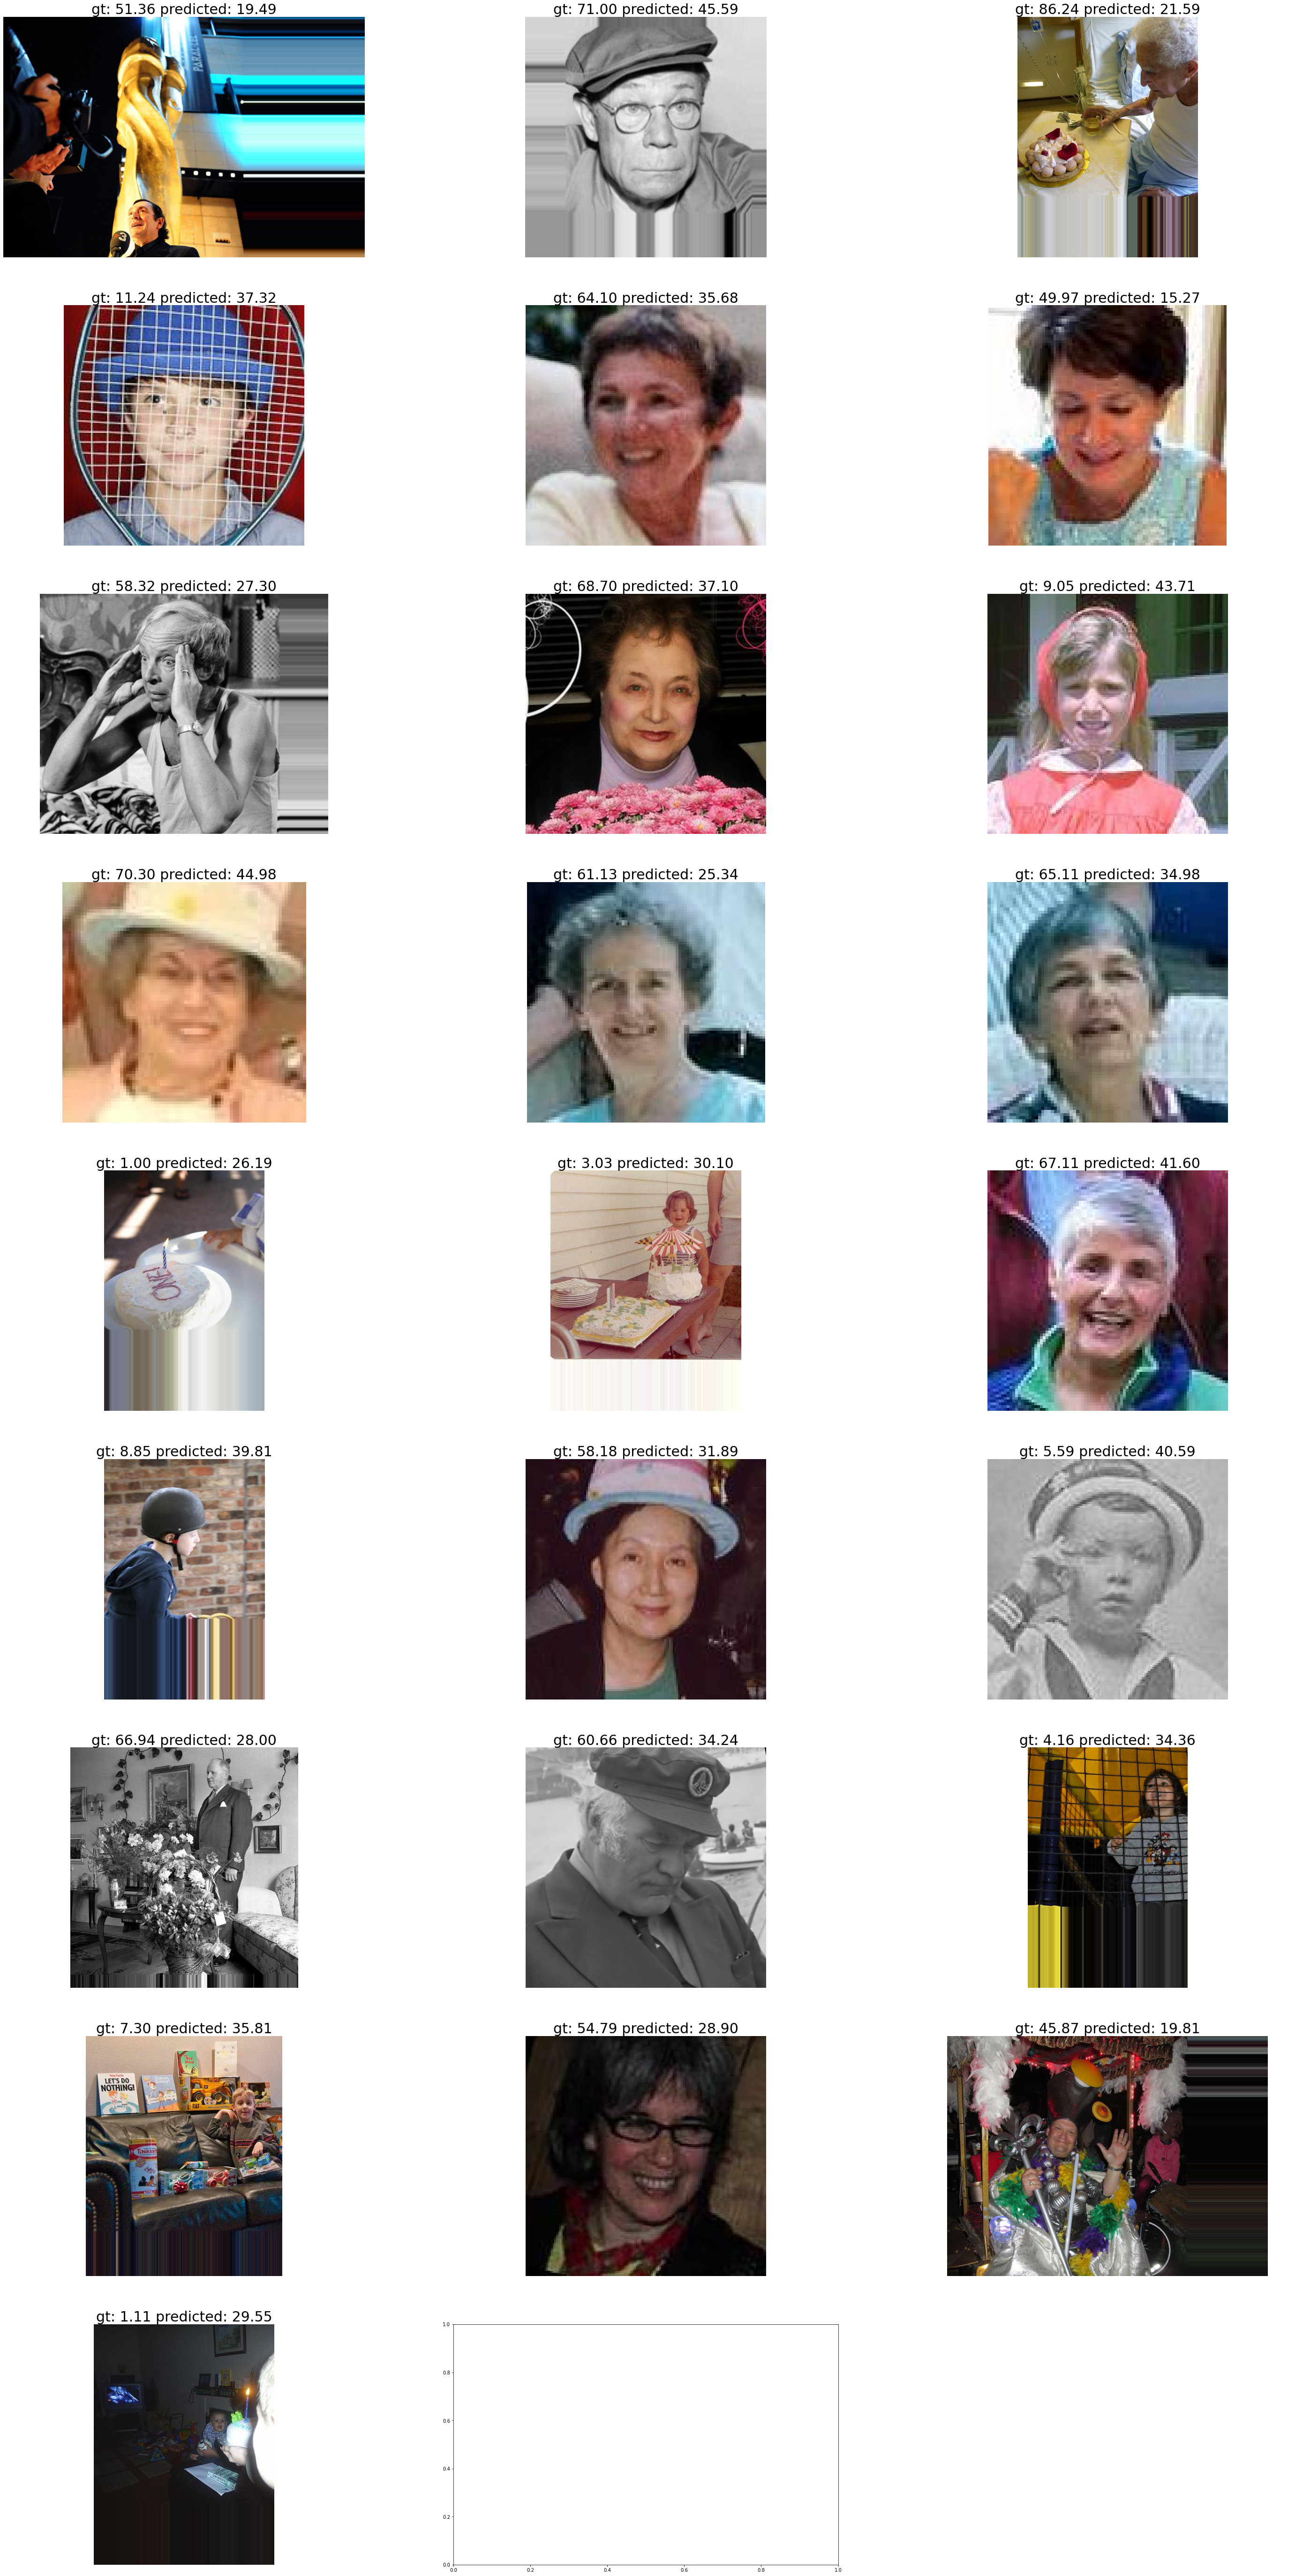

In [9]:
nb_row , nb_col = 9,3

imgs = [rgb(cv2.imread(data_dir + '/test/' + f + '_face.jpg')) for f in l['file_name']]
fig, axs = plt.subplots(nb_row, nb_col , figsize=(50, 100))
axs = axs.flatten()
plt.axis('off')
for i, (img, ax) in enumerate(zip(imgs, axs)):
    ax.imshow(img, )
    age = l.iloc[i]['apparent_age_avg']
    pred = l.iloc[i]['predicted']
    ax.set_title(f'gt: {age:.2f} predicted: {pred:.2f}', fontsize=30)
    ax.axis('off')
plt.show()